# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from datetime import datetime

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

import seaborn as sns
import math

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from collections import Counter

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=";")
azdias_np = azdias.values

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=";")
print("Data loaded")

Data loaded


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
def parseKeyString(key_missing_or_unknown):
    hasX = 'X' in key_missing_or_unknown
    key_list = []
    if (key_missing_or_unknown != "[]"):
        key_list = key_missing_or_unknown.replace('[','')
        key_list = key_list.replace(']','')
        key_list = list(key_list.split(","))
        if (hasX == False):
            key_list = list(map(int, key_list))
    return key_list, hasX

def collectMissingData(i,j):
    numberOfMissingValuesPerCategory[i] += 1
    numberOfMissingValuesPerPerson[j] +=1

def collectNanData(i,j):
    numberOfNanPerCategory[i] += 1
    numberOfNanPerPerson[j] +=1

In [4]:
#TASK 1: Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value.
numberOfCategories = len(feat_info)
numberOfMissingValuesPerCategory = np.zeros(85)
numberOfMissingValuesPerPerson = np.zeros(891221)
numberOfNanPerCategory = np.zeros(85)
numberOfNanPerPerson = np.zeros(891221)

nanValues = []
missingUnknownValues = []
azdias_np_t = np.transpose(azdias_np)
print(np.shape(azdias_np))
print(np.shape(azdias_np_t))
for i, column in enumerate(azdias_np_t):   #column = category
    print("Column",i,"/",84)
    key_missing_or_unknown = feat_info.iloc[i][3]
    key_list, hasX = parseKeyString(key_missing_or_unknown)
    
    for j, row in enumerate(column):
        value = azdias_np_t[i][j]
        if (pd.isna(value) == True):
            nanValues.append([i, j])
            collectNanData(i,j)
        elif (hasX == True):
            string_value = str(value)
            if (any(key == string_value for key in key_list)):
                missingUnknownValues.append([i, j])
                azdias_np_t[i][j] = np.nan
                collectMissingData(i,j)
        else:
            if (key_missing_or_unknown != "[]" and any(key == value for key in key_list)):
                missingUnknownValues.append([i, j])
                azdias_np_t[i][j] = np.nan
                collectMissingData(i,j)
            elif (key_missing_or_unknown == "[]" and value == key_missing_or_unknown):
                missingUnknownValues.append([i, j])
                azdias_np_t[i][j] = np.nan
                collectMissingData(i,j)
nanValues = np.array(nanValues)
missingUnknownValues = np.array(missingUnknownValues)
azdias = pd.DataFrame(np.transpose(azdias_np_t), columns=azdias.columns)
print("Done")

(891221, 85)
(85, 891221)
Column 0 / 84
Column 1 / 84
Column 2 / 84
Column 3 / 84
Column 4 / 84
Column 5 / 84
Column 6 / 84
Column 7 / 84
Column 8 / 84
Column 9 / 84
Column 10 / 84
Column 11 / 84
Column 12 / 84
Column 13 / 84
Column 14 / 84
Column 15 / 84
Column 16 / 84
Column 17 / 84
Column 18 / 84
Column 19 / 84
Column 20 / 84
Column 21 / 84
Column 22 / 84
Column 23 / 84
Column 24 / 84
Column 25 / 84
Column 26 / 84
Column 27 / 84
Column 28 / 84
Column 29 / 84
Column 30 / 84
Column 31 / 84
Column 32 / 84
Column 33 / 84
Column 34 / 84
Column 35 / 84
Column 36 / 84
Column 37 / 84
Column 38 / 84
Column 39 / 84
Column 40 / 84
Column 41 / 84
Column 42 / 84
Column 43 / 84
Column 44 / 84
Column 45 / 84
Column 46 / 84
Column 47 / 84
Column 48 / 84
Column 49 / 84
Column 50 / 84
Column 51 / 84
Column 52 / 84
Column 53 / 84
Column 54 / 84
Column 55 / 84
Column 56 / 84
Column 57 / 84
Column 58 / 84
Column 59 / 84
Column 60 / 84
Column 61 / 84
Column 62 / 84
Column 63 / 84
Column 64 / 84
Column 65

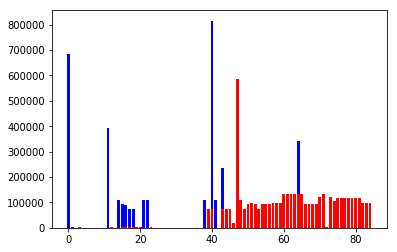

In [5]:
#TASK 2: How much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing
y_pos_miss = np.arange(len(numberOfMissingValuesPerCategory))
plt.bar(y_pos_miss, numberOfMissingValuesPerCategory, color="blue")
y_pos_nan = np.arange(len(numberOfNanPerCategory))
plt.bar(y_pos_miss, numberOfNanPerCategory, color="red")
plt.show()
#All spikes are removed with a threshold of 200,000

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

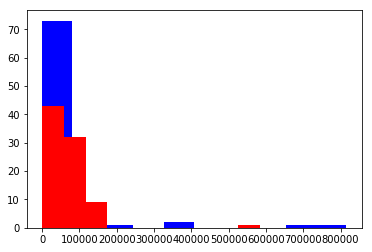

In [6]:
#TASK 3: use matplotlib's hist() function to visualize the distribution of missing value counts to find these columns
plt.hist(numberOfMissingValuesPerCategory, color="blue")
plt.hist(numberOfNanPerCategory, color="red")
plt.show()
#All spikes are removed with a threshold of 200,000

In [7]:
#TASK 4: Remove the outlier columns from the dataset
droppingColumns = []
#Schafer ( 1999 ) asserted that a missing rate of 5% or less is inconsequential.
#Bennett ( 2001 ) maintained that statistical analysis is likely to be biased when more than 10% of data are missing.
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3701793/#:~:text=Proportion%20of%20missing%20data,-The%20proportion%20of&text=Yet%2C%20there%20is%20no%20established,5%25%20or%20less%20is%20inconsequential.

fivePercent = 891221 * 0.05
tenPercent =  891221 * 0.1
spikes = 200000
print(fivePercent, tenPercent, spikes)

for i,entry in enumerate(numberOfMissingValuesPerCategory):
    if (entry > spikes):
        droppingColumns.append(i)
        
for i,entry in enumerate(numberOfNanPerCategory):
    if (entry > spikes):
        droppingColumns.append(i)

print(droppingColumns)
azdias.drop(azdias.columns[droppingColumns], axis=1, inplace=True)

44561.05 89122.1 200000
[0, 11, 40, 43, 64, 47]


In [8]:
#Update values computed

azdias_np2 = azdias.values

def collectNanData(i,j):
    numberOfNanPerCategoryNew[i] += 1
    numberOfNanPerPersonNew[j] +=1
    
numberOfNanPerCategoryNew = np.zeros(85)
numberOfNanPerPersonNew = np.zeros(891221)

azdias_np_t2 = np.transpose(azdias_np2)
for i, column in enumerate(azdias_np_t2):   #column = category
    print("Column",i)
    for j, row in enumerate(column):
        if (pd.isna(azdias_np_t2[i][j]) == True):
            collectNanData(i,j)
    
print("Done")

Column 0
Column 1
Column 2
Column 3
Column 4
Column 5
Column 6
Column 7
Column 8
Column 9
Column 10
Column 11
Column 12
Column 13
Column 14
Column 15
Column 16
Column 17
Column 18
Column 19
Column 20
Column 21
Column 22
Column 23
Column 24
Column 25
Column 26
Column 27
Column 28
Column 29
Column 30
Column 31
Column 32
Column 33
Column 34
Column 35
Column 36
Column 37
Column 38
Column 39
Column 40
Column 41
Column 42
Column 43
Column 44
Column 45
Column 46
Column 47
Column 48
Column 49
Column 50
Column 51
Column 52
Column 53
Column 54
Column 55
Column 56
Column 57
Column 58
Column 59
Column 60
Column 61
Column 62
Column 63
Column 64
Column 65
Column 66
Column 67
Column 68
Column 69
Column 70
Column 71
Column 72
Column 73
Column 74
Column 75
Column 76
Column 77
Column 78
Done


#### Discussion 1.1.2: Assess Missing Data in Each Column

- Amount of missing data in each column --> There is quite a lot of data missing. There are no exact values, but some experts suggest that categories with more than 10% missing value loose quite some meaning. Around 50% of all categories have more than 10% of data missing
- Are there any patterns in missing values? --> The second half of the dataset if full of NaN-values, while the missing values are spread over multiple sections
- Which columns were removed from the dataset? --> 11, 40, 43, 64, 0, 47

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

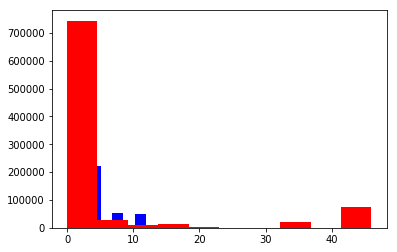

In [9]:
#TASK 5: How much data is missing in each row of the dataset?
plt.hist(numberOfMissingValuesPerPerson, color="blue")
plt.hist(numberOfNanPerPerson, color="red")
plt.show()

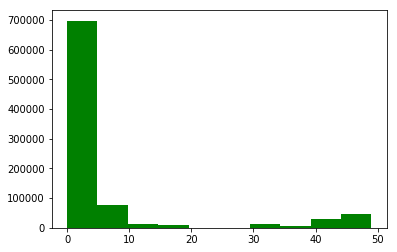

In [10]:
#TASK 5: How much data is missing in each row of the dataset?
plt.hist(numberOfNanPerPersonNew, color="green")
#plt.plot(numberOfNanPerPersonNew, color="orange")
plt.show()

In [11]:
#TASK 6: Divide the data into two subsets:
# one for data points that are above some threshold for missing values,
# and a second subset for points below that threshold.

threshold = 30

#https://knowledge.udacity.com/questions/236887
# Write code to divide the data into two subsets based on the number of missing # values in each row.
belowThreshold = azdias[azdias.isnull().sum(axis=1) <= threshold]
aboveThreshold = azdias[azdias.isnull().sum(axis=1) > threshold]

azdias_subset = belowThreshold
print("Done")

Done


In [12]:
#Find columns with few missing values
#https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe

na_count_above = aboveThreshold.isnull().sum(axis = 0)
na_count_below = belowThreshold.isnull().sum(axis = 0)

print(na_count_above, na_count_below)

#Zero NaNs in both sets:
#FINANZ_MINIMALIST             
#HEALTH_TYP                    
#NATIONALITAET_KZ
#PRAEGENDE_JUGENDJAHRE
#SEMIO_ERL

ALTERSKATEGORIE_GROB        78
ANREDE_KZ                    0
CJT_GESAMTTYP              105
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GFK_URLAUBERTYP            105
GREEN_AVANTGARDE             0
HEALTH_TYP               74470
LP_LEBENSPHASE_FEIN      47393
LP_LEBENSPHASE_GROB      47226
LP_FAMILIE_FEIN          46318
LP_FAMILIE_GROB          46318
LP_STATUS_FEIN             105
LP_STATUS_GROB             105
NATIONALITAET_KZ         74392
PRAEGENDE_JUGENDJAHRE    79406
RETOURTYP_BK_S             105
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
                         ...  
MIN_GEBAEUDEJAHR         93148
OST_WEST

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


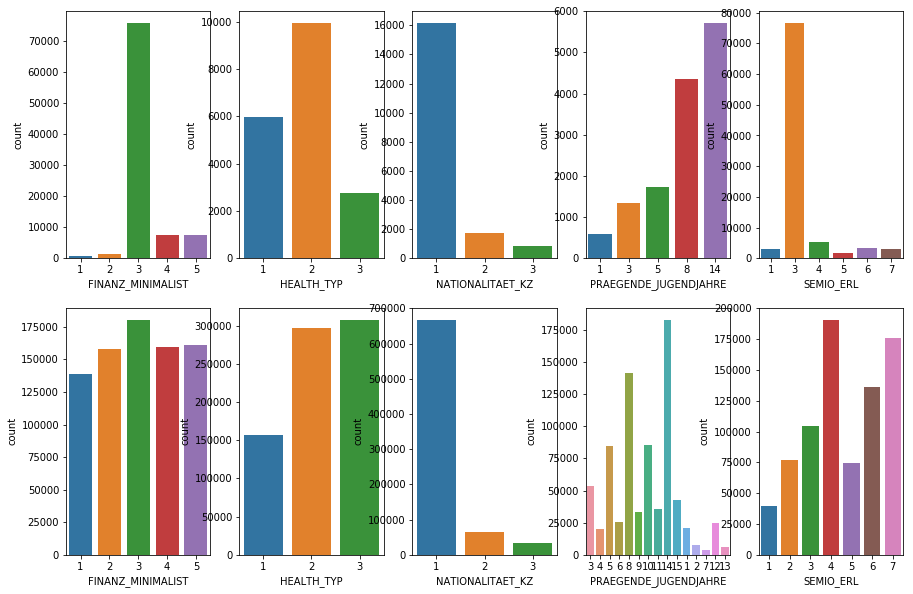

In [13]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# You can use seaborn's countplot() function to create a bar chart of code frequencies and matplotlib's subplot() function to put bar charts for the two subplots side by side.
# To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

fig, axes = plt.subplots(2, 5, figsize=(15,10))

#sns.set(style="darkgrid") 
sns.countplot(x="FINANZ_MINIMALIST", data=aboveThreshold, ax = axes[0][0])
sns.countplot(x="FINANZ_MINIMALIST", data=belowThreshold, ax = axes[1][0])
sns.countplot(x="HEALTH_TYP", data=aboveThreshold, ax = axes[0][1])
sns.countplot(x="HEALTH_TYP", data=belowThreshold, ax = axes[1][1])
sns.countplot(x="NATIONALITAET_KZ", data=aboveThreshold, ax = axes[0][2])
sns.countplot(x="NATIONALITAET_KZ", data=belowThreshold, ax = axes[1][2])
sns.countplot(x="PRAEGENDE_JUGENDJAHRE", data=aboveThreshold, ax = axes[0][3])
sns.countplot(x="PRAEGENDE_JUGENDJAHRE", data=belowThreshold, ax = axes[1][3])
sns.countplot(x="SEMIO_ERL", data=aboveThreshold, ax = axes[0][4])
sns.countplot(x="SEMIO_ERL", data=belowThreshold, ax = axes[1][4])
fig.show()

#https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html

#### Discussion 1.1.3: Assess Missing Data in Each Row

- Observations regarding missing data in rows --> The data quality is not so great, around 100,000 people have 30+ missing features, which is around 1/3 of all avaialable features. Those removed, the remaining dataset is pretty decent though with way less misssing features
- Are the data with lots of missing values are qualitatively different from data with few or no missing values? --> They are mostly quite different, as you can see in the plot above. I chose columns of different categories to get a wider spread of information but still the distributions vary a lot, only "NATIONALITAET_KZ" seems to have some similarity

**I'll continue the analysis using just the subset of the data with few or no missing values.**


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [14]:
# How many features are there of each data type?
#Types: 4: categorical, ordinal, numeric, mixed             
print("Feature info",feat_info)

categorical = feat_info[feat_info['type'] == 'categorical']
ordinal = feat_info[feat_info['type'] == 'ordinal']
numeric = feat_info[feat_info['type'] == 'numeric']
mixed = feat_info[feat_info['type'] == 'mixed']

print("# of Categorical:",len(categorical))
print("# of Ordinal:", len(ordinal))
print("# of Numeric:",len(numeric))
print("# of Mixed:",len(mixed))

#Categorial and mixed need work

Feature info                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [15]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
names = categorical['attribute'].values
names = ['ANREDE_KZ' ,'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE' ,'LP_FAMILIE_FEIN' ,'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP' ,'SOHO_KZ', 
 'VERS_TYP' ,'ZABEOTYP' , 'GEBAEUDETYP' ,'OST_WEST_KZ',
 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
#print("Categorical", names)
#print(azdias_subset[names])

#https://chrisalbon.com/python/data_wrangling/pandas_list_unique_values_in_column/
for column in names:
    print("Column:", column)
    print(len(azdias_subset[column].unique()), azdias_subset[column].unique())

#Binary:
#Column: ANREDE_KZ
#2 [2 1]
#Column: GREEN_AVANTGARDE
#2 [0 1]
#Column: SOHO_KZ
#2 [ 1.  0.]
#Column: OST_WEST_KZ
#2 ['W' 'O']

#Multi-level:
#Column: CJT_GESAMTTYP
#7 [  5.   3.   2.   4.   1.   6.  nan]
#Column: FINANZTYP
#6 [1 6 5 2 4 3]
#Column: GFK_URLAUBERTYP
#13 [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
#Column: LP_FAMILIE_FEIN
#13 [  5.   1.   0.  10.   2.   7.  11.   8.   4.   6.  nan   9.   3.]
#Column: LP_FAMILIE_GROB
#7 [  3.   1.   0.   5.   2.   4.  nan]
#Column: LP_STATUS_FEIN
#11 [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
#Column: LP_STATUS_GROB
#6 [  1.   2.   4.   5.   3.  nan]
#Column: NATIONALITAET_KZ
#4 [1 3 2 0]
#Column: SHOPPER_TYP
#5 [ 3  2  1  0 -1]
#Column: VERS_TYP
#3 [ 2  1 -1]
#Column: ZABEOTYP
#6 [5 3 4 1 6 2]
#Column: GEBAEUDETYP
#7 [ 8.  1.  3.  2.  6.  4.  5.]
#Column: CAMEO_DEUG_2015
#20 ['8' '4' '2' '6' '1' '9' '5' '7' nan '3' 'X' 3.0 8.0 7.0 4.0 1.0 5.0 9.0
# 2.0 6.0]
#Column: CAMEO_DEU_2015
#46 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
# nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
# '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
# 'XX']

Column: ANREDE_KZ
2 [2 1]
Column: CJT_GESAMTTYP
7 [5.0 3.0 2.0 4.0 1.0 6.0 nan]
Column: FINANZTYP
6 [1 6 5 2 4 3]
Column: GFK_URLAUBERTYP
13 [10.0 1.0 5.0 12.0 9.0 3.0 8.0 11.0 4.0 2.0 7.0 6.0 nan]
Column: GREEN_AVANTGARDE
2 [0 1]
Column: LP_FAMILIE_FEIN
12 [5.0 1.0 nan 10.0 2.0 7.0 11.0 8.0 4.0 6.0 9.0 3.0]
Column: LP_FAMILIE_GROB
6 [3.0 1.0 nan 5.0 2.0 4.0]
Column: LP_STATUS_FEIN
11 [2.0 3.0 9.0 4.0 1.0 10.0 5.0 8.0 6.0 7.0 nan]
Column: LP_STATUS_GROB
6 [1.0 2.0 4.0 5.0 3.0 nan]
Column: NATIONALITAET_KZ
4 [1 3 2 nan]
Column: SHOPPER_TYP
5 [3 2 1 0 nan]
Column: SOHO_KZ
2 [1.0 0.0]
Column: VERS_TYP
3 [2 1 nan]
Column: ZABEOTYP
6 [5 3 4 1 6 2]
Column: GEBAEUDETYP
7 [8.0 1.0 3.0 2.0 6.0 4.0 5.0]
Column: OST_WEST_KZ
2 ['W' 'O']
Column: CAMEO_DEUG_2015
10 ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
Column: CAMEO_DEU_2015
45 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D

In [16]:
#https://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
def add_dummy_column(df, string):
    df = pd.concat([df,pd.get_dummies(df[string], prefix=string,dummy_na=True)],axis=1).drop([string],axis=1)
    return df

In [17]:

#For this one, you need to re-encode the values as numbers or create a dummy variable.
#Column: OST_WEST_KZ
#2 ['W' 'O']
azdias_subset = add_dummy_column(azdias_subset, 'OST_WEST_KZ')

#For multi-level categoricals encode the values using multiple dummy variables (e.g. via OneHotEncoder
azdias_subset = add_dummy_column(azdias_subset, 'CJT_GESAMTTYP')
azdias_subset = add_dummy_column(azdias_subset, 'FINANZTYP')
azdias_subset = add_dummy_column(azdias_subset, 'GFK_URLAUBERTYP')
azdias_subset = add_dummy_column(azdias_subset, 'LP_FAMILIE_FEIN')
azdias_subset = add_dummy_column(azdias_subset, 'LP_FAMILIE_GROB')
azdias_subset = add_dummy_column(azdias_subset, 'LP_STATUS_FEIN')
azdias_subset = add_dummy_column(azdias_subset, 'LP_STATUS_GROB')
azdias_subset = add_dummy_column(azdias_subset, 'NATIONALITAET_KZ')
azdias_subset = add_dummy_column(azdias_subset, 'SHOPPER_TYP')
azdias_subset = add_dummy_column(azdias_subset, 'VERS_TYP')
azdias_subset = add_dummy_column(azdias_subset, 'ZABEOTYP')
azdias_subset = add_dummy_column(azdias_subset, 'GEBAEUDETYP')
azdias_subset = add_dummy_column(azdias_subset, 'CAMEO_DEUG_2015')
azdias_subset = add_dummy_column(azdias_subset, 'CAMEO_DEU_2015')

#### Discussion 1.2.1: Re-Encode Categorical Features

I kept all and used get_dummies to encode them.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [18]:
print("Mixed",mixed)
names = mixed['attribute'].values
#KeyError: 'KBA05_BAUMAX'
names = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

#https://chrisalbon.com/python/data_wrangling/pandas_list_unique_values_in_column/
for column in names:
    print("Column:", column)
    print(len(azdias_subset[column].unique()), azdias_subset[column].unique())



Mixed                 attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
64           KBA05_BAUMAX     microcell_rr3  mixed             [-1,0]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]
Column: LP_LEBENSPHASE_FEIN
41 [21.0 3.0 nan 32.0 8.0 2.0 5.0 10.0 4.0 6.0 23.0 12.0 20.0 1.0 11.0 25.0
 13.0 18.0 31.0 38.0 35.0 30.0 7.0 22.0 14.0 29.0 24.0 28.0 37.0 26.0 39.0
 27.0 36.0 9.0 34.0 33.0 15.0 40.0 16.0 19.0 17.0]
Column: LP_LEBENSPHASE_GROB
13 [6.0 1.0 nan 10.0 2.0 3.0 5.0 7.0 12.0 11.0 9.0 4.0 8.0]
Column: WOHNLAGE
8 [4.0 2.0 7.0 3.0 5.0 1.0 8.0 0.0]
Column: PLZ8_BAUMAX
6 [1.0 2.0 nan 4.0 5.0 3.0]


In [19]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#"PRAEGENDE_JUGENDJAHRE" combines information on three dimensions:
#generation by decade, movement (mainstream vs. avantgarde),
#and nation (east vs. west). While there aren't enough levels to disentangle east from west,
#you should create two new variables to capture the other two dimensions:
#an interval-type variable for decade, and a binary variable for movement.

#https://stackoverflow.com/questions/31103040/adding-an-np-array-as-a-column-in-a-pandas-dataframe

PRAEGENDE_JUGENDJAHRE_DECADE = np.empty(np.shape(azdias_subset)[0])
PRAEGENDE_JUGENDJAHRE_DECADE[:] = np.NaN

PRAEGENDE_JUGENDJAHRE_MOVEMENT = np.empty(np.shape(azdias_subset)[0])
PRAEGENDE_JUGENDJAHRE_MOVEMENT[:] = np.NaN

print("BEFORE:", np.shape(azdias_subset))
#https://stackoverflow.com/questions/36757965/how-to-have-multiple-conditions-for-one-if-statement-in-python?noredirect=1&lq=1

decade40s = [1,2]
decade50s = [3,4]
decade60s = [5,6,7]
decade70s = [8,9]
decade80s = [10,11,12,13]
decade90s = [14,15]

movement_mainstream = [1,3,5,8,10,12,14]
movement_avantgarde = [2,4,6,7,9,11,13,15]

for i, entry in enumerate(azdias_subset['PRAEGENDE_JUGENDJAHRE']):
    if (pd.isna(entry) == False):
        value = int(entry)
        if (any(key == value for key in decade40s)):
            PRAEGENDE_JUGENDJAHRE_DECADE[i] = 4
        elif (any(key == value for key in decade50s)):
            PRAEGENDE_JUGENDJAHRE_DECADE[i] = 5
        elif (any(key == value for key in decade60s)):
            PRAEGENDE_JUGENDJAHRE_DECADE[i] = 6
        elif (any(key == value for key in decade70s)):
            PRAEGENDE_JUGENDJAHRE_DECADE[i] = 7
        elif (any(key == value for key in decade80s)):
            PRAEGENDE_JUGENDJAHRE_DECADE[i] = 8
        elif (any(key == value for key in decade90s)):
            PRAEGENDE_JUGENDJAHRE_DECADE[i] = 9

        if (any(key == value for key in movement_mainstream)):
            PRAEGENDE_JUGENDJAHRE_MOVEMENT[i] = 0
        elif (any(key == value for key in movement_avantgarde)):
            PRAEGENDE_JUGENDJAHRE_MOVEMENT[i] = 1

print(PRAEGENDE_JUGENDJAHRE_DECADE)
print(PRAEGENDE_JUGENDJAHRE_MOVEMENT)

azdias_subset['PRAEGENDE_JUGENDJAHRE_DECADE'] = PRAEGENDE_JUGENDJAHRE_DECADE
azdias_subset['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = PRAEGENDE_JUGENDJAHRE_MOVEMENT

azdias_subset.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
print("AFTER:", np.shape(azdias_subset))


BEFORE: (798067, 211)
[ 9.  9.  7. ...,  9.  9.  5.]
[ 0.  1.  0. ...,  0.  0.  0.]
AFTER: (798067, 212)


In [20]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#Combines information on two axes: wealth and life stage.
#Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new
#ordinal variables (which, for the purposes of this project, is equivalent to just treating
#them as their raw numeric values).

CAMEO_INTL_2015_WEALTH = np.empty(np.shape(azdias_subset)[0])
CAMEO_INTL_2015_WEALTH[:] = np.NaN

CAMEO_INTL_2015_LIFESTAGE = np.empty(np.shape(azdias_subset)[0])
CAMEO_INTL_2015_LIFESTAGE[:] = np.NaN

print("BEFORE:", np.shape(azdias_subset))
#https://stackoverflow.com/questions/36757965/how-to-have-multiple-conditions-for-one-if-statement-in-python?noredirect=1&lq=1

for i, entry in enumerate(azdias_subset['CAMEO_INTL_2015']):
    if (pd.isna(entry) == False):
        value = int(entry)
        digits = (int)(math.log10(value)) 
        first = (int)(value / pow(10, digits)) 
        last = (value % 10) 
        CAMEO_INTL_2015_WEALTH[i] = first
        CAMEO_INTL_2015_LIFESTAGE[i] = last

print(CAMEO_INTL_2015_WEALTH)
print(CAMEO_INTL_2015_LIFESTAGE)
        
azdias_subset['CAMEO_INTL_2015_WEALTH'] = CAMEO_INTL_2015_WEALTH
azdias_subset['CAMEO_INTL_2015_LIFESTAGE'] = CAMEO_INTL_2015_LIFESTAGE
#
azdias_subset.drop('CAMEO_INTL_2015', axis=1, inplace=True)
print("AFTER:", np.shape(azdias_subset))

BEFORE: (798067, 212)
[ 5.  2.  1. ...,  2.  5.  4.]
[ 1.  4.  2. ...,  4.  1.  3.]
AFTER: (798067, 213)


In [21]:
#handling of further mixed values
azdias_subset.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
azdias_subset.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
azdias_subset.drop('WOHNLAGE', axis=1, inplace=True)
azdias_subset.drop('PLZ8_BAUMAX', axis=1, inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

- Reporting your findings and decisions regarding mixed-value features --> It's quite a lot of work if people don't have machine learning in mind when they create a dataset, especially those mixed-types
- Which ones did you keep, which did you drop, and what engineering steps did you perform? --> I kept the two necessary and dropped the rest

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#This is all done already

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#This is all done already

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [ ]:
#FURTHER DOWN

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [22]:
fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
imputer_transform = fill_NaN.fit_transform(azdias_subset)
imputed_DF = pd.DataFrame(imputer_transform)
imputed_DF.columns = azdias_subset.columns
imputed_DF.index = azdias_subset.index

In [23]:
# Apply feature scaling to the general population demographics data.
ss = StandardScaler()
scaler_transform = ss.fit_transform(imputed_DF)
df_scaled = pd.DataFrame(scaler_transform,columns = imputed_DF.columns)
print("Scaling done")

Scaling done


### Discussion 2.1: Apply Feature Scaling

- reporting your decisions regarding feature scaling --> I chose an imputer with mean-values to fill NaN and the suggested StandardScaler afterwards

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [24]:
# Apply PCA to the data.
pca = PCA()
principalComponents = pca.fit_transform(df_scaled)

0 : 0.0611227468753
1 : 0.112966922479
2 : 0.149399615951
3 : 0.18170763229
4 : 0.206701673169
5 : 0.2304357846
6 : 0.252620657704
7 : 0.26992832988
8 : 0.285395905646
9 : 0.299445902161
10 : 0.313072160797
11 : 0.325878993234
12 : 0.338193265746
13 : 0.350182033327
14 : 0.361849056034
15 : 0.372841327391
16 : 0.383773345667
17 : 0.394486978044
18 : 0.405072245284
19 : 0.415574249765
20 : 0.426042180149
21 : 0.436420005242
22 : 0.446558249166
23 : 0.456617859362
24 : 0.466323765563
25 : 0.475836692951
26 : 0.484908317663
27 : 0.493448641022
28 : 0.501746184886
29 : 0.509822444345
30 : 0.517367118021
31 : 0.524825308186
32 : 0.53184068996
33 : 0.538824232756
34 : 0.545513029284
35 : 0.552154834295
36 : 0.558629172939
37 : 0.56484959194
38 : 0.571034003168
39 : 0.577090564746
40 : 0.583134890862
41 : 0.589086653235
42 : 0.594855355279
43 : 0.600526739214
44 : 0.606154223748
45 : 0.611714335562
46 : 0.617272772836
47 : 0.622738096884
48 : 0.628177054107
49 : 0.633557253202
50 : 0.63891593

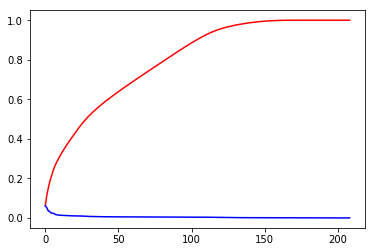

In [25]:
# Investigate the variance accounted for by each principal component.
#pca_results(df_scaled, pca)#takes very long

#print(pca.components_)
#print(pca.explained_variance_)

#plt.plot(pca.explained_variance_,color="red")
currentPercentage = 0
mySum = np.empty(len(pca.explained_variance_ratio_))
for i, entry in enumerate(pca.explained_variance_ratio_):
    currentPercentage += entry
    mySum[i] = currentPercentage
    print(i,":",currentPercentage)
    
plt.plot(mySum,color="red")
plt.plot(pca.explained_variance_ratio_,color="blue")
plt.show()

In [26]:
# Re-apply PCA to the data while selecting for number of components to retain.
#85% can be explained with ~100 components
n_components = 100
pca = PCA(n_components)
pca.fit(df_scaled)
principalComponents = pca.transform(df_scaled)
print("PCA done")

PCA done


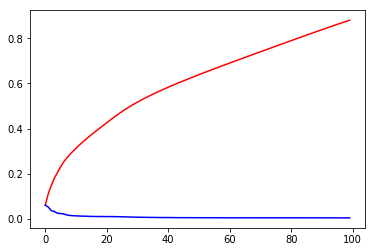

In [27]:
currentPercentage = 0
mySum = np.empty(len(pca.explained_variance_ratio_))
for i, entry in enumerate(pca.explained_variance_ratio_):
    currentPercentage += entry
    mySum[i] = currentPercentage
    
plt.plot(mySum,color="red")
plt.plot(pca.explained_variance_ratio_,color="blue")
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

- reporting your findings and decisions regarding dimensionality reduction --> There is no component with a HUGE impact, the strongest ones accounts for 6% of the variance
- How many principal components / transformed features are you retaining for the next step of the analysis? I chose 100 to roughly cover more than 85 %, reducing the size of the components by roughly 50 %

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [28]:
def plotSingleDimension(full_dataset, pca, index):
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    ## PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    ## PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    feature_weights = pca.components_
    numerOfFeatures = np.shape(full_dataset)[1]
    
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    #plt.bar(range(numerOfFeatures),feature_weights[index])
    #plt.show()
    
    result = pd.concat([variance_ratios, components], axis = 1).iloc[index,:].sort_values(ascending=False)

    return result

In [29]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
#pca_results(df_scaled, pca)
plotSingleDimension(df_scaled, pca, 0)

FINANZ_MINIMALIST               0.2264
MOBI_REGIO                      0.1732
KBA05_ANTG1                     0.1612
KBA05_GBZ                       0.1594
FINANZ_VORSORGER                0.1320
KONSUMNAEHE                     0.1278
LP_STATUS_GROB_4.0              0.1273
LP_STATUS_FEIN_9.0              0.1234
PLZ8_ANTG1                      0.1182
INNENSTADT                      0.1162
LP_STATUS_GROB_5.0              0.1159
LP_STATUS_FEIN_10.0             0.1159
ALTERSKATEGORIE_GROB            0.1096
PLZ8_GBZ                        0.1082
CAMEO_INTL_2015_LIFESTAGE       0.1035
GREEN_AVANTGARDE                0.1001
FINANZTYP_2.0                   0.0996
NATIONALITAET_KZ_1.0            0.0982
MIN_GEBAEUDEJAHR                0.0981
GEBAEUDETYP_RASTER              0.0943
GEBAEUDETYP_1.0                 0.0935
ZABEOTYP_1.0                    0.0891
BALLRAUM                        0.0876
KBA05_ANTG2                     0.0837
CAMEO_DEUG_2015_2               0.0829
ANZ_PERSONEN             

In [30]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plotSingleDimension(df_scaled, pca, 1)

FINANZ_UNAUFFAELLIGER           0.2099
FINANZ_SPARER                   0.1933
SEMIO_REL                       0.1889
SEMIO_TRADV                     0.1796
SEMIO_PFLICHT                   0.1768
FINANZ_ANLEGER                  0.1748
PRAEGENDE_JUGENDJAHRE_DECADE    0.1680
MOBI_REGIO                      0.1595
KBA05_GBZ                       0.1589
KBA05_ANTG1                     0.1566
SEMIO_RAT                       0.1463
SEMIO_KULT                      0.1419
MIN_GEBAEUDEJAHR                0.1398
ONLINE_AFFINITAET               0.1397
KBA05_ANTG2                     0.1365
KBA05_ANTG4                     0.1321
SEMIO_MAT                       0.1288
KBA05_ANTG3                     0.1285
SEMIO_FAM                       0.1236
PLZ8_ANTG1                      0.1220
PLZ8_GBZ                        0.1198
FINANZTYP_3.0                   0.1137
FINANZTYP_1.0                   0.1058
KKK                             0.0966
PLZ8_HHZ                        0.0876
ZABEOTYP_4.0             

In [31]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plotSingleDimension(df_scaled, pca, 2)

PLZ8_ANTG3                0.2240
PLZ8_ANTG4                0.2235
PLZ8_ANTG2                0.2162
KBA05_ANTG3               0.2138
KBA05_ANTG4               0.2135
PLZ8_HHZ                  0.2041
SEMIO_KRIT                0.1983
SEMIO_KAEM                0.1982
KBA05_ANTG2               0.1978
ANREDE_KZ                 0.1935
MIN_GEBAEUDEJAHR          0.1724
PLZ8_GBZ                  0.1627
SEMIO_ERL                 0.1621
PLZ8_ANTG1                0.1568
SEMIO_DOM                 0.1494
KBA05_ANTG1               0.1466
KBA05_GBZ                 0.1444
MOBI_REGIO                0.1341
REGIOTYP                  0.0998
ZABEOTYP_3.0              0.0988
KKK                       0.0972
CAMEO_INTL_2015_WEALTH    0.0845
LP_FAMILIE_FEIN_1.0       0.0755
LP_FAMILIE_GROB_1.0       0.0755
LP_STATUS_GROB_1.0        0.0709
VERS_TYP_nan              0.0649
SHOPPER_TYP_nan           0.0649
FINANZ_HAUSBAUER          0.0648
NATIONALITAET_KZ_nan      0.0631
SHOPPER_TYP_3.0           0.0626
          

### Discussion 2.3: Interpret Principal Components

- Reporting your observations from detailed investigation of the first few principal components generated -->
0:
- FINANZ_MINIMALIST               0.2264 | low financial interest
- MOBI_REGIO                      0.1732 | Movement patterns
- KBA05_ANTG1                     0.1612 | Number of 1-2 family houses in the microcell
- FINANZ_SPARER                  -0.1712 | money-saver
- HH_EINKOMMEN_SCORE             -0.1907 | Estimated household net income
- LP_STATUS_GROB_1.0             -0.2003 | low-income earners

1:
- FINANZ_UNAUFFAELLIGER           0.2099 | inconspicuous
- FINANZ_SPARER                   0.1933 | money-saver
- SEMIO_REL                       0.1889 | religious
- ALTERSKATEGORIE_GROB           -0.1697 | Estimated age based on given name analysis
- ZABEOTYP_3.0                   -0.1805 | Energy consumption typology: fair supplied
- FINANZ_VORSORGER               -0.1908 | be prepared

2:
- PLZ8_ANTG3                0.2240 | Number of 6-10 family houses in the PLZ8 region
- PLZ8_ANTG4                0.2235 | Number of 10+ family houses in the PLZ8 region
- PLZ8_ANTG2                0.2162 | Number of 3-5 family houses in the PLZ8 region
- SEMIO_VERT               -0.1675 | dreamful
- SEMIO_SOZ                -0.1695 | socially-minded
- SEMIO_KULT               -0.1919 | cultural-minded
- Can we interpret positive and negative values from them in a meaningful way? --> We can see the fincial values seem to be of a high importance, followed by personality typologies

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


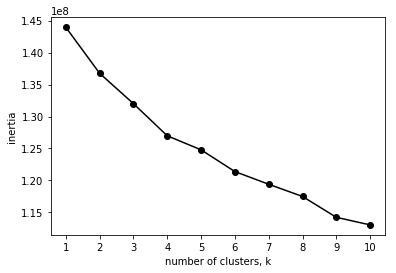

In [32]:
# Over a number of different cluster counts...
PCA_components = pd.DataFrame(principalComponents)

ks = range(1, 11)
inertias = []
scores = []
silhouettes = []

numberOfSamples = np.shape(principalComponents)[1]

for k in ks:
    print("Iteration",k)
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    fit = model.fit(PCA_components)
    predictions = fit.predict(PCA_components)
    
    #https://stackoverflow.com/questions/51382250/valueerror-number-of-labels-is-1-valid-values-are-2-to-n-samples-1-inclusiv
    #Silhouette score leads to memory error (https://stackoverflow.com/questions/16424724/how-can-i-fix-a-memoryerror-when-executing-scikit-learns-silhouette-score)
    #if (k>1):
    #    silhouette_avg = silhouette_score(PCA_components, predictions)
    #    silhouettes.append(silhouette_avg)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    scores.append(model.score(PCA_components)/numberOfSamples)

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
    

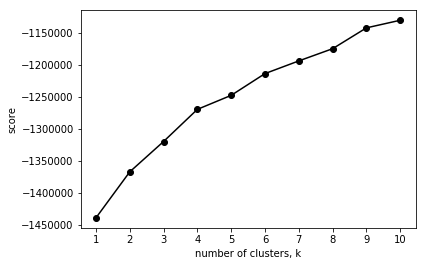

In [33]:
#Score returns "Sum of distances of samples to their closest cluster center."
#Wanted: average within-cluster distances

plt.plot(ks, scores, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('score')
plt.xticks(ks)
plt.show()

In [34]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

#5 seems to be the ell-bow point
PCA_components = pd.DataFrame(principalComponents)
k = 5
kmeans_model = KMeans(n_clusters=k) 
kmeans_fit = model.fit(PCA_components)
kmeans_predictions = kmeans_fit.predict(PCA_components)


### Discussion 3.1: Apply Clustering to General Population

- Reporting your findings and decisions regarding clustering
- Into how many clusters have you decided to segment the population? --> It seems to be a hard one here to decide since there's no "true" ellbow point. I chose the first time the slope decreased, setting k to 5

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [9]:
def add_dummy_column(df, string):
    df = pd.concat([df,pd.get_dummies(df[string], prefix=string,dummy_na=True)],axis=1).drop([string],axis=1)
    return df

def clean_data(df, below):
    numberOfCategories = np.shape(df)[1]
    numberOfPersons = np.shape(df)[0]
    
    df_np = df.values
    df_t = np.transpose(df_np)
    
    for i, column in enumerate(df_t):   #column = category
        key_missing_or_unknown = feat_info.iloc[i][3]
        key_list, hasX = parseKeyString(key_missing_or_unknown)

        for j, row in enumerate(column):
            value = df_t[i][j]
            if (hasX == True):
                string_value = str(value)
                if (any(key == string_value for key in key_list)):
                    df_t[i][j] = np.nan
            else:
                if (key_missing_or_unknown != "[]" and any(key == value for key in key_list)):
                    df_t[i][j] = np.nan
                elif (key_missing_or_unknown == "[]" and value == key_missing_or_unknown):
                    df_t[i][j] = np.nan
                    
    df = pd.DataFrame(np.transpose(df_t), columns=df.columns)
    print("1 Inserting NaN Done",np.shape(df))
    
    # remove selected columns and rows, ...
    droppingColumns = [0, 11, 40, 43, 64, 47]
    df.drop(df.columns[droppingColumns], axis=1, inplace=True)
    print("2 Dropping Columns Done",np.shape(df))

    threshold = 30
    if (below == True):
        df = df[df.isnull().sum(axis=1) <= threshold]
    else:
        df = df[df.isnull().sum(axis=1) > threshold]
    print("3 Dropping Rows Done",np.shape(df))
    
    # select, re-encode, and engineer column values.
    df = add_dummy_column(df, 'OST_WEST_KZ')

    #For multi-level categoricals encode the values using multiple dummy variables (e.g. via OneHotEncoder
    df = add_dummy_column(df, 'CJT_GESAMTTYP')
    df = add_dummy_column(df, 'FINANZTYP')
    df = add_dummy_column(df, 'GFK_URLAUBERTYP')
    df = add_dummy_column(df, 'LP_FAMILIE_FEIN')
    df = add_dummy_column(df, 'LP_FAMILIE_GROB')
    df = add_dummy_column(df, 'LP_STATUS_FEIN')
    df = add_dummy_column(df, 'LP_STATUS_GROB')
    df = add_dummy_column(df, 'NATIONALITAET_KZ')
    df = add_dummy_column(df, 'SHOPPER_TYP')
    df = add_dummy_column(df, 'VERS_TYP')
    df = add_dummy_column(df, 'ZABEOTYP')
    df = add_dummy_column(df, 'GEBAEUDETYP')
    df = add_dummy_column(df, 'CAMEO_DEUG_2015')
    df = add_dummy_column(df, 'CAMEO_DEU_2015')
    
    print("4 OneHotEncoding Done",np.shape(df))
    
    PRAEGENDE_JUGENDJAHRE_DECADE = np.empty(np.shape(df)[0])
    PRAEGENDE_JUGENDJAHRE_DECADE[:] = np.NaN

    PRAEGENDE_JUGENDJAHRE_MOVEMENT = np.empty(np.shape(df)[0])
    PRAEGENDE_JUGENDJAHRE_MOVEMENT[:] = np.NaN

    decade40s = [1,2]
    decade50s = [3,4]
    decade60s = [5,6,7]
    decade70s = [8,9]
    decade80s = [10,11,12,13]
    decade90s = [14,15]

    movement_mainstream = [1,3,5,8,10,12,14]
    movement_avantgarde = [2,4,6,7,9,11,13,15]

    for i, entry in enumerate(df['PRAEGENDE_JUGENDJAHRE']):
        if (pd.isna(entry) == False):
            value = int(entry)
            if (any(key == value for key in decade40s)):
                PRAEGENDE_JUGENDJAHRE_DECADE[i] = 4
            elif (any(key == value for key in decade50s)):
                PRAEGENDE_JUGENDJAHRE_DECADE[i] = 5
            elif (any(key == value for key in decade60s)):
                PRAEGENDE_JUGENDJAHRE_DECADE[i] = 6
            elif (any(key == value for key in decade70s)):
                PRAEGENDE_JUGENDJAHRE_DECADE[i] = 7
            elif (any(key == value for key in decade80s)):
                PRAEGENDE_JUGENDJAHRE_DECADE[i] = 8
            elif (any(key == value for key in decade90s)):
                PRAEGENDE_JUGENDJAHRE_DECADE[i] = 9

            if (any(key == value for key in movement_mainstream)):
                PRAEGENDE_JUGENDJAHRE_MOVEMENT[i] = 0
            elif (any(key == value for key in movement_avantgarde)):
                PRAEGENDE_JUGENDJAHRE_MOVEMENT[i] = 1

    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = PRAEGENDE_JUGENDJAHRE_DECADE
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = PRAEGENDE_JUGENDJAHRE_MOVEMENT
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    CAMEO_INTL_2015_WEALTH = np.empty(np.shape(df)[0])
    CAMEO_INTL_2015_WEALTH[:] = np.NaN
    CAMEO_INTL_2015_LIFESTAGE = np.empty(np.shape(df)[0])
    CAMEO_INTL_2015_LIFESTAGE[:] = np.NaN

    for i, entry in enumerate(df['CAMEO_INTL_2015']):
        if (pd.isna(entry) == False):
            value = int(entry)
            digits = (int)(math.log10(value)) 
            first = (int)(value / pow(10, digits)) 
            last = (value % 10) 
            CAMEO_INTL_2015_WEALTH[i] = first
            CAMEO_INTL_2015_LIFESTAGE[i] = last

    df['CAMEO_INTL_2015_WEALTH'] = CAMEO_INTL_2015_WEALTH
    df['CAMEO_INTL_2015_LIFESTAGE'] = CAMEO_INTL_2015_LIFESTAGE
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    #handling of further mixed values
    df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    df.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    df.drop('WOHNLAGE', axis=1, inplace=True)
    df.drop('PLZ8_BAUMAX', axis=1, inplace=True)
    
    print("5 Feature Engineering Done",np.shape(df))
    # Return the cleaned dataframe.
    return df

def parseKeyString(key_missing_or_unknown):
    hasX = 'X' in key_missing_or_unknown
    key_list = []
    if (key_missing_or_unknown != "[]"):
        key_list = key_missing_or_unknown.replace('[','')
        key_list = key_list.replace(']','')
        key_list = list(key_list.split(","))
        if (hasX == False):
            key_list = list(map(int, key_list))
    return key_list, hasX

In [7]:
#+++ ANALYSIS PART IS COMPLETELY DONE --> HOW TO CLEAN PROCESS CAN BE AUTOMATED  +++
#From here on it's kind of a "restart" with freshly imported data

# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=";")
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=";")
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=";")
print(np.shape(azdias))
print(np.shape(customers))

(891221, 85)
(191652, 85)


In [10]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
print("+++Cleaning AZDIAS+++")
cleaned_germany_data = clean_data(azdias, True)
print("6 Cleaning done!")

print("+++Getting AZDIAS Above Threshold+++")
cleaned_germany_data_above_threshold = clean_data(azdias, False)
print("6 Cleaning done!")

print("+++Cleaning CUSTOMERS+++")
cleaned_customer_data = clean_data(customers, True)
print("6 Cleaning done!")

print("+++Getting CUSTOMERS Anove Threshold+++")
cleaned_customer_data_above_threshold = clean_data(customers, False)
print("6 Cleaning done!")

#ALIGNING data
cleaned_germany_data = cleaned_germany_data[cleaned_customer_data.columns]
cleaned_germany_data_above_threshold = cleaned_germany_data_above_threshold[cleaned_customer_data_above_threshold.columns]

print(np.shape(cleaned_germany_data))
print(np.shape(cleaned_customer_data))
print("BELOW Datasets have same amount of columns")
print(np.shape(cleaned_germany_data_above_threshold))
print(np.shape(cleaned_customer_data_above_threshold))
print("ABOVE Datasets have same amount of columns")

+++Cleaning AZDIAS+++
1 Inserting NaN Done (891221, 85)
2 Dropping Columns Done (891221, 79)
3 Dropping Rows Done (798067, 79)
4 OneHotEncoding Done (798067, 211)
5 Feature Engineering Done (798067, 209)
6 Cleaning done!
+++Getting AZDIAS Above Threshold+++
1 Inserting NaN Done (891221, 85)
2 Dropping Columns Done (891221, 79)
3 Dropping Rows Done (93154, 79)
4 OneHotEncoding Done (93154, 161)
5 Feature Engineering Done (93154, 159)
6 Cleaning done!
+++Cleaning CUSTOMERS+++
1 Inserting NaN Done (191652, 85)
2 Dropping Columns Done (191652, 79)
3 Dropping Rows Done (141725, 79)
4 OneHotEncoding Done (141725, 210)
5 Feature Engineering Done (141725, 208)
6 Cleaning done!
+++Getting CUSTOMERS Anove Threshold+++
1 Inserting NaN Done (191652, 85)
2 Dropping Columns Done (191652, 79)
3 Dropping Rows Done (49927, 79)
4 OneHotEncoding Done (49927, 149)
5 Feature Engineering Done (49927, 147)
6 Cleaning done!
(798067, 208)
(141725, 208)
BELOW Datasets have same amount of columns
(93154, 147)
(4

In [11]:
#Redo fitting etc. for identical datasets now
def impute_scale_pca_kmeans_TRAININGSET(df):
    fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
    imputer_fit = fill_NaN.fit(df)
    imputer_transform = imputer_fit.transform(df)
    imputed_DF = pd.DataFrame(imputer_transform)
    imputed_DF.columns = df.columns
    imputed_DF.index = df.index
    print("1 Imputer done")

    ss_model = StandardScaler()
    scaler_fit = ss_model.fit(imputed_DF)
    scaler_transform = scaler_fit.transform(imputed_DF)
    df_scaled = pd.DataFrame(scaler_transform,columns = imputed_DF.columns)
    print("2 Scaling done")

    n_components = 100
    pca_model = PCA(n_components)
    pca_fit = pca_model.fit(df_scaled)
    principalComponents = pca_fit.transform(df_scaled)
    print("3 PCA done")

    PCA_components = pd.DataFrame(principalComponents)
    k = 5
    kmeans_model = KMeans(n_clusters=k) 
    kmeans_fit = kmeans_model.fit(PCA_components)
    kmeans_predictions = kmeans_fit.predict(PCA_components)
    print("4 K-Means done")
    
    return kmeans_predictions, principalComponents, imputer_fit, scaler_fit, pca_fit, kmeans_fit

def impute_scale_pca_kmeans_TESTSET(df, imputer_fit, scaler_fit, pca_fit, kmeans_fit):
    
    imputer_transform = imputer_fit.transform(df)
    imputed_DF = pd.DataFrame(imputer_transform)
    imputed_DF.columns = df.columns
    imputed_DF.index = df.index
    print("1 Imputer done")

    scaler_transform = scaler_fit.transform(imputed_DF)
    df_scaled = pd.DataFrame(scaler_transform,columns = imputed_DF.columns)
    print("2 Scaling done")

    principalComponents = pca_fit.transform(df_scaled)
    PCA_components = pd.DataFrame(principalComponents)
    print("3 PCA done")

    kmeans_predictions = kmeans_fit.predict(PCA_components)
    print("4 K-Means done")
    
    return kmeans_predictions, principalComponents

In [12]:
kmeans_predictions_germany, principalComponents_germany, imputer_fit, scaler_fit, pca_fit, kmeans_fit = impute_scale_pca_kmeans_TRAININGSET(cleaned_germany_data)
kmeans_predictions_customer, principalComponents_customer = impute_scale_pca_kmeans_TESTSET(cleaned_customer_data, imputer_fit, scaler_fit, pca_fit, kmeans_fit)

print(np.shape(kmeans_predictions_germany))
print(np.shape(kmeans_predictions_customer))


1 Imputer done
2 Scaling done
3 PCA done
4 K-Means done
1 Imputer done
2 Scaling done
3 PCA done
4 K-Means done
(798067,)
(141725,)


In [13]:
kmeans_predictions_germany_above, principalComponents_germany_above, imputer_fit_above, scaler_fit_above, pca_fit_above, kmeans_fit_above = impute_scale_pca_kmeans_TRAININGSET(cleaned_germany_data_above_threshold)
kmeans_predictions_customer_above, principalComponents_customer_above = impute_scale_pca_kmeans_TESTSET(cleaned_customer_data_above_threshold, imputer_fit_above, scaler_fit_above, pca_fit_above, kmeans_fit_above)

print(np.shape(kmeans_predictions_germany_above))
print(np.shape(kmeans_predictions_customer_above))

1 Imputer done
2 Scaling done
3 PCA done
4 K-Means done
1 Imputer done
2 Scaling done
3 PCA done
4 K-Means done
(93154,)
(49927,)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

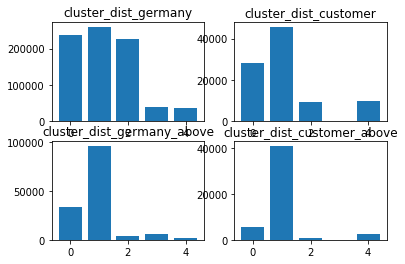

In [14]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
cluster_dist_germany = Counter(kmeans_predictions_germany)
cluster_dist_customer = Counter(kmeans_predictions_germany_above)
cluster_dist_germany_above = Counter(kmeans_predictions_customer)
cluster_dist_customer_above = Counter(kmeans_predictions_customer_above)

#https://stackoverflow.com/questions/52572094/how-to-plot-collections-counter-histogram-using-matplotlib/52572237


fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(cluster_dist_germany.keys(),cluster_dist_germany.values())
axs[0, 0].set_title('cluster_dist_germany')
axs[0, 1].bar(cluster_dist_customer.keys(),cluster_dist_customer.values())
axs[0, 1].set_title('cluster_dist_customer')
axs[1, 0].bar(cluster_dist_germany_above.keys(),cluster_dist_germany_above.values())
axs[1, 0].set_title('cluster_dist_germany_above')
axs[1, 1].bar(cluster_dist_customer_above.keys(),cluster_dist_customer_above.values())
axs[1, 1].set_title('cluster_dist_customer_above')
plt.show()

In [15]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#https://knowledge.udacity.com/questions/180641

#Below threshold:
#Cluster 1 

#What kind of people might be represented by that cluster?
#A high value in one of the columns,
#say the age group 30 - 60 years would mean that the particular cluster
#has a large number of people in the above age group.
print("cluster_customer_below_1_result")
cluster_customer_below_1_data = scaler_fit.inverse_transform(pca_fit.inverse_transform(kmeans_fit.cluster_centers_[1]))
cluster_customer_below_1_result = pd.Series(data = cluster_customer_below_1_data, index = cleaned_customer_data.columns)
cluster_customer_below_1_result = cluster_customer_below_1_result.sort_values(ascending=False)
print(cluster_customer_below_1_result.head())

#Above threshold:
#Cluster 2
print("cluster_customer_above_2_result")
cluster_customer_above_2_data = scaler_fit_above.inverse_transform(pca_fit_above.inverse_transform(kmeans_fit_above.cluster_centers_[2]))
cluster_customer_above_2_result = pd.Series(data = cluster_customer_above_2_data, index = cleaned_customer_data_above_threshold.columns)
cluster_customer_above_2_result = cluster_customer_above_2_result.sort_values(ascending=False)
print(cluster_customer_above_2_result.head())

cluster_customer_below_1_result
MIN_GEBAEUDEJAHR                1993.094945
KBA13_ANZAHL_PKW                 680.161795
WOHNDAUER_2008                     8.455900
PRAEGENDE_JUGENDJAHRE_DECADE       6.852145
INNENSTADT                         5.468431
dtype: float64
cluster_customer_above_2_result
WOHNDAUER_2008                  7.725675
PRAEGENDE_JUGENDJAHRE_DECADE    6.460737
SEMIO_MAT                       5.749143
SEMIO_FAM                       5.626554
SEMIO_REL                       5.229211
dtype: float64


In [16]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#Below threshold:
#Cluster 3+4
print("cluster_customer_below_3_result")
cluster_customer_below_3_data = scaler_fit.inverse_transform(pca_fit.inverse_transform(kmeans_fit.cluster_centers_[3]))
cluster_customer_below_3_result = pd.Series(data = cluster_customer_below_3_data, index = cleaned_customer_data.columns)
cluster_customer_below_3_result = cluster_customer_below_3_result.sort_values(ascending=False)
print(cluster_customer_below_3_result.head())

print("cluster_customer_below_4_result")
cluster_customer_below_4_data = scaler_fit.inverse_transform(pca_fit.inverse_transform(kmeans_fit.cluster_centers_[4]))
cluster_customer_below_4_result = pd.Series(data = cluster_customer_below_4_data, index = cleaned_customer_data.columns)
cluster_customer_below_4_result = cluster_customer_below_4_result.sort_values(ascending=False)
print(cluster_customer_below_4_result.head())
#Above threshold:
#Cluster 3+4
#Above threshold:
#Cluster 2
print("cluster_customer_above_3_result")
cluster_customer_above_3_data = scaler_fit_above.inverse_transform(pca_fit_above.inverse_transform(kmeans_fit_above.cluster_centers_[3]))
cluster_customer_above_3_result = pd.Series(data = cluster_customer_above_3_data, index = cleaned_customer_data_above_threshold.columns)
cluster_customer_above_3_result = cluster_customer_above_3_result.sort_values(ascending=False)
print(cluster_customer_above_3_result.head())

print("cluster_customer_above_4_result")
cluster_customer_above_4_data = scaler_fit_above.inverse_transform(pca_fit_above.inverse_transform(kmeans_fit_above.cluster_centers_[4]))
cluster_customer_above_4_result = pd.Series(data = cluster_customer_above_4_data, index = cleaned_customer_data_above_threshold.columns)
cluster_customer_above_4_result = cluster_customer_above_4_result.sort_values(ascending=False)
print(cluster_customer_above_4_result.head())


cluster_customer_below_3_result
MIN_GEBAEUDEJAHR    2003.966540
KBA13_ANZAHL_PKW     608.104987
KBA05_GBZ             13.903350
MOBI_REGIO            13.859842
KBA05_ANTG2           13.719674
dtype: float64
cluster_customer_below_4_result
MIN_GEBAEUDEJAHR                1992.627873
KBA13_ANZAHL_PKW                 584.652659
HEALTH_TYP                        13.634879
ANZ_HAUSHALTE_AKTIV               11.737084
PRAEGENDE_JUGENDJAHRE_DECADE      10.975683
dtype: float64
cluster_customer_above_3_result
MIN_GEBAEUDEJAHR                2006.166667
KBA13_ANZAHL_PKW                 132.171614
PRAEGENDE_JUGENDJAHRE_DECADE      18.083688
PLZ8_ANTG2                        18.083688
KBA05_ANTG3                       18.083688
dtype: float64
cluster_customer_above_4_result
WOHNDAUER_2008    8.079126
SEMIO_KRIT        5.635738
SEMIO_ERL         5.253567
SEMIO_VERT        5.091571
SEMIO_KAEM        4.949206
dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

- Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

It seems strongly that the values of "building year" and "number of cars" are highly related to both beeing part of the popular and the unpopular group in the datasets "BELOW THRESHOLD". In the datasets "ABOVE THRESHHOLD" we can see that different attributes come to play, even though one unpopular cluster is also strongly defined by the same two metrics.

+++BELOW THRESHOLD +++
POPULAR:
- cluster_customer_below_1_result
- MIN_GEBAEUDEJAHR    2003.970793 --> First year building was mentioned in the database
- KBA13_ANZAHL_PKW     605.006558 --> Number of cars in the PLZ8 region
- KBA05_GBZ             13.908382
- MOBI_REGIO            13.863695
- KBA05_ANTG2           13.725372

UNPOPULAR:
- cluster_customer_below_3_result
- MIN_GEBAEUDEJAHR                1992.413808 --> First year building was mentioned in the database
- KBA13_ANZAHL_PKW                 554.683779 --> Number of cars in the PLZ8 region
- ANZ_HAUSHALTE_AKTIV               14.416252
- WOHNDAUER_2008                     8.087347
- PRAEGENDE_JUGENDJAHRE_DECADE       6.580938

cluster_customer_below_4_result
- MIN_GEBAEUDEJAHR                1993.095572 --> First year building was mentioned in the database
- KBA13_ANZAHL_PKW                 679.694094 --> Number of cars in the PLZ8 region
- WOHNDAUER_2008                     8.462296
- PRAEGENDE_JUGENDJAHRE_DECADE       6.848973
- INNENSTADT                        5.470161

+++ABOVE THRESHOLD +++
POPULAR:
cluster_customer_above_2_result
- SEMIO_REL     7.000000 --> religious
- SEMIO_KRIT    6.999934 --> critical-minded
- SEMIO_FAM     6.000000
- SEMIO_DOM     5.999956
- SEMIO_KAEM    5.999956

UNPOPULAR:
- cluster_customer_above_3_result
- MIN_GEBAEUDEJAHR                2006.166667  --> First year building was mentioned in the database
- KBA13_ANZAHL_PKW                 132.171614  --> Number of cars in the PLZ8 region
- HEALTH_TYP                        18.083688
- PRAEGENDE_JUGENDJAHRE_DECADE      18.083688
- REGIOTYP                          18.083688

cluster_customer_above_4_result
WOHNDAUER_2008    8.079126 --> Length of residence
- SEMIO_KRIT        5.635738  --> critical-minded
- SEMIO_ERL         5.253567
- SEMIO_VERT        5.091571
- SEMIO_KAEM        4.949206


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.